In [1]:
import pandas as pd
import random
from utils import *
from back_classes.sentence_classifier import SentenceClassifier
from back_classes.tokenizer_class import TokenizerClass
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from datasets import Dataset
from transformers import DataCollatorWithPadding
from evaluate import load
import numpy as np
trans_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-german-cased')
import os
os.environ['TOKENIZERS_PARALLELISM']='1'
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Function definition*

In [2]:
wandb.init(
    project='pretrain-transform-wiki',

    config={
    'class_size':2000,
    'random_state':2,
    'eval_metric':'accuracy',
    'eval_share':0.25,
    'batch_size':256, #256
    'epochs':4,
    'huggingface_model':'distilbert-base-german-cased',
    'loss_function':None,
    'learning_rate':0.00032,
    }
)
config=wandb.config

wandb: Currently logged in as: ether-meter. Use `wandb login --relogin` to force relogin


In [3]:
def preprocess_transformer_token(example):
    return trans_tokenizer(example['text'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=trans_tokenizer)

accuracy = load(config.eval_metric)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



*Create trainining & eval dataset*

In [4]:
class_size = config.class_size

all_articles=pd.read_csv('/data/fulltext_wiki_protected.csv',sep=',')[['title','bytes','full_text']]
i=1
df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[0])
while i<len(all_articles):
    working_df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[i])
    df=pd.concat([df,working_df])
    i+=1
    
df['label']=df['target']
df=df[['text','label']]
claim_tokenizer=TokenizerClass()
claim_extract=SentenceClassifier(claim_tokenizer)
claim_extract.preprocess_train_val(df,target_column='label')

wiki_dataset = Dataset.from_pandas(df_finetune,preserve_index=False)
tokenized_wiki = wiki_dataset.map(preprocess_transformer_token,batched=True)
split_tokenized = tokenized_wiki.train_test_split(config.eval_share)




  0%|          | 0/4 [00:00<?, ?ba/s]

# Tensorflow

In [5]:
from transformers import create_optimizer
import tensorflow as tf
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from transformers import TFAutoModelForSequenceClassification

batch_size = config.batch_size
num_epochs = config.epochs
batches_per_epoch = len(split_tokenized['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=config.learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps)


model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-german-cased", num_labels=2,from_pt=True)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-20 11:22:56.611696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 11:22:56.612033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification mode

In [6]:
tf_train_set = model.prepare_tf_dataset(
    split_tokenized['train'],
    shuffle=True,
    batch_size=config.batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    split_tokenized["test"],
    shuffle=False,
    batch_size=config.batch_size,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer,)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [7]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)
push_to_hub_callback = PushToHubCallback(
    output_dir="new_version123",
    tokenizer=trans_tokenizer,
)

callbacks = [metric_callback, push_to_hub_callback,WandbMetricsLogger(log_freq=5),WandbModelCheckpoint('models')]

/Users/jannis/Desktop/GitRepos/Master/masterthesis/Master_Thesis/new_version123 is already a clone of https://huggingface.co/whathefish/new_version123. Make sure you pull the latest changes with `repo.git_pull()`.


## Train 

In [8]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=config.epochs, callbacks=callbacks)

Epoch 1/4


2023-02-20 11:22:59.666513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 11:23:03.656096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2:30 - loss: 0.7522

KeyboardInterrupt: 

In [ ]:
print(tf.test.is_gpu_available) 

<function is_gpu_available at 0x2976ec820>


## Evaluate w/ test-data

In [ ]:
annotated=pd.read_csv('FullAnnotated1.csv',sep=';',dtype={'sentence':'str'})
annotated=annotated[annotated['to_exclude']==0]
df_test=pd.DataFrame()
df_test['text']=annotated['sentence']
df_test['label']=annotated['is_claim']
dataset_test=Dataset.from_pandas(df_test,preserve_index=False)
sentence_list = list(df_test['text'])
tokenized = trans_tokenizer(sentence_list,return_tensors='np',padding='longest')
outputs = model(tokenized).logits




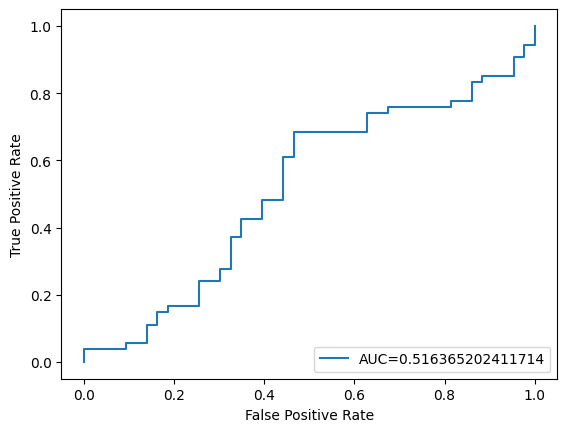

In [ ]:
softmaxed = tf.nn.softmax(outputs)
softmaxed = softmaxed.numpy()
probabilities =[]
for i in softmaxed:
    probabilities.append((i)[1])
a,b=plot_compute_AUC(annotated['is_claim'],  probabilities)

In [ ]:
print(b)

0.516365202411714


In [ ]:
classifications = np.argmax(outputs,axis=1)
ground_truth = list(classifications)
predictions = list(df_test['label'])
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions)
recall = recall_score(ground_truth, predictions)
f1score=f1_score(ground_truth, predictions)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
wandb.log({'AUC':b,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1score})

Accuracy: 0.52, Precision: 0.91, Recall: 0.54


In [ ]:
wandb.finish()
raise KeyboardInterrupt("Until autorun till here!")


batch/batch_step,▁█
batch/learning_rate,█▁
batch/loss,▁█
batch/batch_step,5
batch/learning_rate,0.00027
batch/loss,0.70237


KeyboardInterrupt: Until autorun till here!

# Pytorch

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-german-cased", num_labels=2
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_tokenized['train'],
    eval_dataset=split_tokenized['test'],
    tokenizer=trans_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


